In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from torch.utils.data import TensorDataset
import torch.nn.functional as F
import torch
from dltools.functions import create_learner, get_dls, get_model, get_model_func, listify, rmsle, normalize
from dltools.data import proc_df, TypeSelector
from dltools.databunch import DataBunch
from dltools.runner import Runner
from dltools.callback import AvgStatsCallback, sched_lin, sched_cos, Recorder, AvgStatsCallback, ParamScheduler, combine_scheds
from dltools.metrics import avg_deviation

ImportError: cannot import name 'proc_df'

In [3]:
from pathlib import Path
import pandas as pd


def get_data():
    device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

    PATH = Path('../data/houseprice/')
    df_train = pd.read_csv(PATH/'train.csv', sep=',', header=0)
    df_y = df_train['SalePrice']
    df_train.drop(['SalePrice'], axis=1, inplace=True)
    df_test = pd.read_csv(PATH/'test.csv', sep=',', header=0)

    cat_names = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
        'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
        'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
        'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
        'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
        'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
        'MoSold', 'YrSold', 'SaleType', 'SaleCondition']

    cont_names = [name for name in df_train.columns if name not in cat_names]
    proc_train, proc_test = proc_df(cont_names, cat_names, df_train, df_test)

    x_train = torch.tensor(proc_train.values[:1168], dtype=torch.float32, device=device)
    y_train = torch.tensor(df_y.values[:1168], dtype=torch.float32, device=device) #.reshape(-1,1)
    x_valid = torch.tensor(proc_train.values[1168:], dtype=torch.float32, device=device)
    y_valid = torch.tensor(df_y.values[1168:], dtype=torch.float32, device=device) #.reshape(-1,1)
    x_test = torch.tensor(proc_test.values, dtype=torch.float32, device=device)

    return (x_train, y_train, x_valid, y_valid, x_test)

In [4]:
from functools import partial

In [ ]:
# from housepricemanual import *

In [ ]:
# !type housepricemanual.py

In [ ]:
# !dir PATH

## Get data

### get_data()

In [ ]:
x_train, y_train, x_valid, y_valid, x_test = get_data()

In [ ]:
x_train[:,:22].mean()

In [ ]:
torch.cat([x_train, x_valid, x_test], dim=0)[:, :22].mean()

In [ ]:
n, m = x_train.shape
# c = y_train.max()+1
# x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

In [ ]:
train_mean, train_std = x_train.mean(), x_train.std()
train_mean, train_std

In [ ]:
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)
x_test = normalize(x_test, train_mean, train_std)

In [ ]:
x_train.mean(), x_train.std()

### Check mean, std

In [ ]:
x_train.mean(), x_train.std()

In [ ]:
y_train.shape

In [ ]:
assert n==y_train.shape[0]==1168

## Initial python model

### Matmul

In [ ]:
x_train.shape, x_valid.shape

In [ ]:
weights = torch.randn(481, 10)
bias = torch.zeros(10)

In [ ]:
weights, weights.shape, bias

In [ ]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar,bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i,j] += a[i,k] * b[k,j]
    return c

In [ ]:
m1 = x_valid[:5]
m2 = weights

In [ ]:
m1.shape, m2.shape

In [ ]:
%time t1 = matmul(m1,m2)

In [ ]:
t1.shape

In [ ]:
len(x_train)

In [ ]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar,bc)
    
    for i in range(ar):
        for j in range(bc):
            c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

In [ ]:
%timeit -n 10 _=matmul(m1, m2)

In [ ]:
t1.dtype

In [ ]:
def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near)

In [ ]:
test_near(t1, matmul(m1, m2))

#### Broadcasting

In [ ]:
mm = tensor([[1., 2, 3], [4,5,6], [7,8,9]]); mm

In [ ]:
cc = tensor([10., 20, 30]); cc

In [ ]:
2*mm

In [ ]:
tt = cc.expand_as(mm); tt

In [ ]:
mm+tt

In [ ]:
tt.storage()

In [ ]:
cc, cc.shape, cc.unsqueeze(0)

#### Matmul with broadcasting

In [ ]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar,bc)
    for i in range(ar):
        c[i] = (a[i].unsqueeze(-1) * b).sum(dim=0)
    return c

In [ ]:
%timeit -n 10 _=matmul(m1,m2)

In [ ]:
test_near(t1, matmul(m1,m2))

#### Matmul with Pytorch op

In [ ]:
%timeit -n 10 t2 = m1.matmul(m2)

In [ ]:
t2 = m1@m2

In [ ]:
test_near(t1, t2)

In [ ]:
m1.shape, m2.shape

### Basic architecture - weight init

#### Manual kaiming init

In [ ]:
# num hidden
nh = 50

In [ ]:
n, m

In [ ]:
# simplified kaiming init
w1 = torch.randn(m, nh)/math.sqrt(m)
b1 = torch.zeros(nh)
w2 = torch.randn(nh, 1)/math.sqrt(nh)
b2 = torch.zeros(1)

In [ ]:
w1.mean(), w2.std()

In [ ]:
test_near_zero(w1.mean())
test_near_zero(1/math.sqrt(m)-w1.std())

In [ ]:
w1.mean(), w1.std()*math.sqrt(m)

In [ ]:
# Approx. ~(0,1) because of the normalization with training mean and std
x_valid.mean(), x_valid.std()

In [ ]:
def lin(x, w, b):
    return x@w+b

In [ ]:
t = lin(x_train, w1, b1)

In [ ]:
# This should also be ~(0,1) because of kaiming init
t.mean(), t.std()

In [ ]:
def relu(x):
    return x.clamp_min(0.)

In [ ]:
t = relu(lin(x_train, w1, b1))

In [ ]:
# This is not ~(0,1) because of the ReLU function
t.mean(), t.std()

In [ ]:
# Kaiming init for ReLU
w1 = torch.randn(m, nh) * math.sqrt(2/m)

In [ ]:
w1.mean(), w1.std(), w1.std()/math.sqrt(2/m)

In [ ]:
t = relu(lin(x_train, w1, b1))
t.mean(), t.std()

#### PyTorch kaiming for w1

In [ ]:
# num hidden
nh = 50

In [ ]:
# Torch kaiming init
w1 = torch.zeros(m, nh)
w1 = init.kaiming_normal_(w1, mode='fan_out')
t = relu(lin(x_train, w1, b1))

In [ ]:
t.mean(), t.std()

In [ ]:
init.kaiming_normal_??

In [ ]:
import torch.nn

In [ ]:
torch.nn.Linear(m, nh).weight.shape

In [ ]:
# Adjusted ReLU
def relu(x):
    return x.clamp_min(0.)-0.5

In [ ]:
# Using kaiming init and ReLU with adjusted mean
w1 = torch.zeros(m, nh)
init.kaiming_normal_(w1, mode='fan_out')
t = relu(lin(x_train, w1, b1))
t.mean(), t.std()

#### Full kaiming init pytorch

In [ ]:
# num hidden
nh = 50

In [ ]:
w1 = torch.zeros(m, nh)
init.kaiming_normal_(w1, mode='fan_out')
b1 = torch.zeros(nh)
w2 = torch.zeros(nh, 1)
init.kaiming_normal_(w2, mode='fan_out')
b2 = torch.zeros(1)

#### Simple model

In [ ]:
def model(xb):
    l1 = lin(xb, w1, b1)
    l2 = relu(l1)
    l3 = lin(l2, w2, b2)
    return l3

In [ ]:
%timeit -n 10 _=model(x_valid)

In [ ]:
assert model(x_valid).shape==torch.Size([x_valid.shape[0], 1])

### Loss function: MSE

In [ ]:
model(x_valid).shape

In [ ]:
mse(model(x_valid), y_valid)

### Loss function: RMSLE

In [ ]:
def rmsle(x, y):
    """
    Compute the Root Mean Squared Log Error for hypthesis h and targets y
    
    Args:
        h - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    return torch.sqrt( ((torch.log(x + 1) - torch.log(y + 1))**2).mean() )

Same as

``nn.functional.mse_loss((model(xb)+1).log().squeeze(), (yb+1).log()).sqrt()``

### Gradients and backward pass

In [ ]:
#gradient of the loss function wrt the output of the previous layer (lin with w2, b2)
def mse_grad(inp, targ):
    inp.g = 2. * (inp.squeeze() - targ).unsqueeze(-1) / inp.shape[0]

In [ ]:
def lin_grad(inp, out, w, b):
    inp.g = out.g @ w.t()
    w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)
    b.g = out.g.sum(0)

In [ ]:
def relu_grad(inp, out):
    # grad of relu wrt input
    inp.g = (inp>0).float() * out.g

In [ ]:
def forward_and_backward(inp, targ):
    # forward
    l1 = inp @ w1 + b1
    l2 = relu(l1)
    out = l2 @ w2 + b2
    loss = mse(out, targ)
    
    # backward
    mse_grad(out, targ)
    lin_grad(l2, out, w2, b2)
    relu_grad(l1, l2)
    lin_grad(inp, l1, w1, b1)

In [ ]:
forward_and_backward(x_train, y_train)

In [ ]:
x_train.g

In [ ]:
# Save for testing against later
w1g = w1.g.clone()
w2g = w2.g.clone()
b1g = b1.g.clone()
b2g = b2.g.clone()
ig  = x_train.g.clone()

Use ``torch.autograd`` to check the results

In [ ]:
xt2 = x_train.clone().requires_grad_(True)
w12 = w1.clone().requires_grad_(True)
b12 = b1.clone().requires_grad_(True)
w22 = w2.clone().requires_grad_(True)
b22 = b2.clone().requires_grad_(True)

In [ ]:
def forward(inp, targ):
    # forward
    l1 = inp @ w12 + b12
    l2 = relu(l1)
    out = l2 @ w22 + b22
    return mse(out, targ)

In [ ]:
loss = forward(xt2, y_train)

In [ ]:
loss.backward()

In [ ]:
test_near(w22.grad, w2.g)
test_near(b22.grad, b2.g)
test_near(w12.grad, w1.g)
test_near(b12.grad, b1.g)
test_near(xt2.grad, x_train.g)

## Refactor model

### Layers as classes

#### No superclass

In [ ]:
class Relu():
    def __call__(self, inp):
        self.inp = inp
        self.out = inp.clamp_min(0.)-0.5
        return self.out
    
    def backward(self):
        self.inp.g = (self.inp>0).float() * self.out.g

In [ ]:
class Lin():
    def __init__(self, w, b):
        self.w = w
        self.b = b
        
    def __call__(self, inp):
        self.inp = inp
        self.out = self.inp @ self.w + self.b
        return self.out
    
    def backward(self):
        self.inp.g = self.out.g @ self.w.t()
        self.w.g = (self.inp.unsqueeze(-1) * self.out.g.unsqueeze(1)).sum(0)
        self.b.g = self.out.g.sum()       

In [ ]:
class Mse():
    def __call__(self, inp, targ):
        self.inp = inp
        self.targ = targ
        self.out = (inp - targ).pow(2).mean()
        return self.out
    
    def backward(self):
        self.inp.g = 2.*(self.inp.squeeze()-self.targ).unsqueeze(-1) / self.inp.shape[0]

In [ ]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1, b1), Relu(), Lin(w2, b2)]
        self.loss = Mse()
    
    def __call__(self, x, targ):
        for l in self.layers:
            x = l(x)
        return self.loss(x, targ)
        # the x in self.loss(x, targ) is the output of the last layer (Lin(w2,b2)) and gets its gradient defined here.
        # This is why out.g is available when called in backward for the first of the reversed layers.

    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers):
            l.backward()

In [ ]:
w1.g, b1.g, w2.g, b2.g = [None]*4

In [ ]:
model = Model(w1, b1, w2, b2)

In [ ]:
%time loss = model(x_valid, y_valid)

In [ ]:
%time loss = model(x_train, y_train)

In [ ]:
%time model.backward()

#### Module superclass with Module.forward()

In [ ]:
class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*self.args)
        return self.out
    
    def forward(self):
        raise Exception(f"not implemented")
    
    def backward(self):
        return self.bwd(self.out, *self.args)

In [ ]:
class Relu(Module):
    def forward(self, inp):
        return inp.clamp_min(0.) - 0.5
    
    def bwd(self, out, inp):
        inp.g = (inp>0).float() * out.g

In [ ]:
class Lin(Module):
    def __init__(self, w, b):
        self.w, self.b = w, b

    def forward(self, inp):
        return inp @ self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = torch.einsum("bi, bj -> ij", inp, out.g)
        self.b.g = out.g.sum(0)

In [ ]:
class Mse(Module):
    def forward(self, inp, targ):
        return (inp.squeeze() - targ).pow(2).mean()
    
    def bwd(self, out, inp, targ):
        inp.g = 2. * (inp.squeeze() - targ).unsqueeze(-1) / inp.shape[0]

In [ ]:
class Model():
    def __init__(self):
        self.layers = [Lin(w1, b2), Relu(), Lin(w2, b2)]
        self.loss = Mse()
    
    def __call__(self, x, targ):
        for l in self.layers:
            x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers):
            l.backward()

In [ ]:
w1.g, b1.g, w2.g, b2.g = [None]*4
model = Model()

In [ ]:
%time loss = model(x_train, y_train)

In [ ]:
%time model.backward()

In [ ]:
x_train.shape, w1.shape, w2.shape

#### Class Lin() without torch.einsum

In [ ]:
class Lin(Module):
    def __init__(self, w, b):
        self.w, self.b = w, b
        
    def forward(self, inp):
        return inp @ self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = inp.t() @ out.g
        self.b.g = out.g.sum(0)

In [ ]:
model = Model()

In [ ]:
%time loss = model(x_train, y_train)

In [ ]:
%time model.backward()

#### nn.Linear and nn.Module

In [ ]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
        self.loss = mse
    
    def __call__(self, x, targ):
        for l in self.layers:
            x = l(x)
        return self.loss(x.squeeze(), targ)

In [ ]:
model = Model(m, nh, 1)

In [ ]:
%time loss = model(x_train, y_train)

In [ ]:
%time loss.backward()

### Training loop

#### Class Model

In [ ]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
        self.loss = mse
    
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

#### Model parameters

In [ ]:
bs = 64               # batchsize
lr = 0.5              # learning rate
epochs = 1
xb, yb = x_train[:bs], y_train[:bs]

In [ ]:
loss_func = rmsle

In [ ]:
# loss_func = nn.MSELoss()

#### fit()

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [ ]:
def fit():
    for e in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb, yb = x_train[start_i:end_i], y_train[start_i:end_i]
            loss = loss_func(model(xb).squeeze(), yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

#### Simplify model to use nn.Sequential

In [ ]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 1)).to(device)

In [ ]:
fit()

### optim pytorch

In [ ]:
opt = optim.SGD(model.parameters(), lr=lr)

### get_model()

In [ ]:
def get_model(device=device):
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 1)).to(device)
    return model, optim.SGD(model.parameters(), lr=lr)

In [ ]:
model, opt = get_model()

In [ ]:
fit()

In [ ]:
loss_func(model(x_train), y_train)

### Dataset, DataLoader

#### Dataset

In [ ]:
class Dataset():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        assert len(self.x)==len(self.y)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [ ]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

#### Dataset check

In [ ]:
assert len(train_ds) == len(y_train)

In [ ]:
model, opt = get_model()

In [ ]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb, yb = train_ds[i*bs:i*bs+bs]
        loss = loss_func(model(xb), yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()       

In [ ]:
loss_func(model(x_train), y_train)

In [ ]:
loss_func(model(x_valid), y_valid)

#### DataLoader

In [ ]:
class DataLoader():
    def __init__(self, ds, bs):
        self.ds = ds
        self.bs = bs
    
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i:i+self.bs]

In [ ]:
train_dl, valid_dl = DataLoader(train_ds, bs), DataLoader(valid_ds, bs)

#### DataLoader check

In [ ]:
xb, yb = next(iter(train_dl))

#### fit() with DataLoader

In [ ]:
model, opt = get_model()

In [ ]:
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [ ]:
fit()

In [ ]:
loss_func(model(xb), yb)

### Random sampling

#### Sampler

In [ ]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):#
        self.n, self.bs, self.shuffle = len(ds), bs, shuffle
    
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs):
            yield self.idxs[i:i+self.bs]

#### Sampler check

In [ ]:
small_ds = Dataset(*train_ds[:10])

In [ ]:
s = Sampler(train_ds, bs, False)
[o for o in s]

In [ ]:
s = Sampler(train_ds, bs, True)

#### Collate()

In [ ]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

#### Collate() check

In [ ]:
train_sampler = Sampler(train_ds, 3, False)

In [ ]:
for s in train_sampler:
    print(collate([train_ds[i] for i in s]))

#### DataLoader with sampler

In [ ]:
class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds, self.sampler, self.collate_fn = ds, sampler, collate_fn
    
    def __iter__(self):
        for s in self.sampler:
            yield self.collate_fn([self.ds[i] for i in s])

In [ ]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [ ]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

#### DataLoader with sampler check

In [ ]:
xb, yb = next(iter(valid_dl))

#### fit() exec

In [ ]:
model, opt = get_model()

In [ ]:
fit()

In [ ]:
loss_func(model(xb), yb)

#### Pytorch DataLoader with Pytorch Sampler

In [ ]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

#### fit() exec

In [ ]:
model, opt = get_model()
fit()
loss_func(model(xb), yb)

### Validation

In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # set model to training mode, which activates the use of batch norm layers, dropout etc
        model.train()
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()            
            opt.step()
            opt.zero_grad()

        # set model to evaluation mode, deactivates use of batch norm, dropout etc
        model.eval()
        with torch.no_grad():
            tot_loss = 0.
            for xb, yb in valid_dl:
                tot_loss += loss_func(model(xb), yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv)
    return tot_loss/nv

In [ ]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()
loss = fit(5, model, loss_func, opt, train_dl, valid_dl)

## DataBunch

### Init

In [ ]:
x_train, y_train, x_valid, y_valid, x_test = get_data()
n, m = x_train.shape
nh, bs = 50, 64
c = 1
loss_func = rmsle

In [ ]:
train_mean, train_std = x_train.mean(), x_train.std()
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)
x_test = normalize(x_test, train_mean, train_std)
x_train.mean(), x_train.std()

In [ ]:
# train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [ ]:
train_ds, valid_ds = TensorDataset(x_train, y_train), TensorDataset(x_valid, y_valid)

### Class DataBunch

#### DataBunch definition and fit

In [ ]:
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl, self.valid_dl, self.c = train_dl, valid_dl, c
    
    @property
    def train_ds(self):
        return self.train_dl.dataset
    
    @property
    def valid_ds(self):
        return self.valid_dl.dataset

In [ ]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

### Learner

In [ ]:
class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model, self.opt, self.loss_func, self.data = model, opt, loss_func, data

In [ ]:
learn = Learner(*get_model(data), loss_func, data)

#### fit exec

In [ ]:
def fit(epochs, learn):
    for epoch in range(epochs):
        learn.model.train()        
        for xb, yb in learn.data.train_dl:
            loss = learn.loss_func(learn.model(xb), yb)
            loss.backward()
            learn.opt.step()
            learn.opt.zero_grad()
        
        learn.model.eval()
        with torch.no_grad():
            tot_loss = 0.
            for xb, yb in learn.data.valid_dl:
                pred = learn.model(xb)
                tot_loss += learn.loss_func(learn.model(xb), yb)
        nv = len(learn.data.valid_dl)
        print(epoch, tot_loss/nv)
    return tot_loss/nv

In [ ]:
loss = fit(1, learn)

#### fit refactor

In [ ]:
def one_batch(xb, yb, cb):
    if not cb.begin_batch(xb, yb): return
    loss = cb.learn.loss_func(cb.learn.model(xb), yb)
    if not cb.after_loss(loss): return
    loss.backward()
    if cb.after_backward(): cb.learn.opt.step()
    if cb.after_step(): cb.learn.opt.zero_grad()

In [ ]:
def all_batches(dl, cb):
    for xb, yb in dl:
        one_batch(xb, yb, cb)
        if cb.do_stop(): return

In [ ]:
def fit(epochs, learn, cb):
    if not cb.begin_fit(learn): return
    for epoch in range(epochs):
        if not cb.begin_epoch(epoch): return
        all_batches(learn.data.train_dl, cb)
        
        if cb.begin_validate():
            with torch.no_grad(): all_batches(learn.data.valid_dl, cb)
        if cb.do_stop() or not cb.after_epoch(): break
    cb.after_fit()  

## Runner

### TestCallback

In [ ]:
from dltools.callback import Callback

In [ ]:
class TestCallback(Callback):
    def after_step(self):
        if self.train_eval.n_iters >= 10:
            return True

In [ ]:
learn = Learner(*get_model(data), loss_func, data)

In [ ]:
stats = AvgStatsCallback([avg_deviation])

In [ ]:
run = Runner(cbs=stats)

In [ ]:
run.fit(2, learn)

### Runner with ParamScheduler annealer 

In [5]:
x_train, y_train, x_valid, y_valid, x_test = get_data()
train_mean, train_std = x_train.mean(), x_train.std()
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)
x_test = normalize(x_test, train_mean, train_std)
x_train.mean(), x_train.std()

(tensor(3.0121e-08), tensor(1.))

In [6]:
train_ds, valid_ds = TensorDataset(x_train, y_train), TensorDataset(x_valid, y_valid)
nh, bs = 50, 128
c = 1
loss_func = rmsle

In [7]:
scheds = [sched_cos(0.3, 0.6), sched_cos(0.6, 0.3)]
pcts = [0.3, 0.7]
scheduler = combine_scheds(pcts, scheds)

In [8]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [9]:
cbfs = [Recorder, partial(AvgStatsCallback, avg_deviation), partial(ParamScheduler, 'lr', scheduler)]

In [10]:
learn = create_learner(get_model_func(0.3), loss_func, data)

In [11]:
run = Runner(cb_funcs = cbfs)

In [12]:
run.fit(3, learn)

train: [8.67458061322774, tensor(180537.0312)]
valid: [7.12652587890625, tensor(182093.2969)]
train: [6.763659333529538, tensor(180367.4375)]
valid: [6.371189483224529, tensor(181920.2969)]
train: [6.244429496869649, tensor(180217.6094)]
valid: [6.075161868578767, tensor(181807.5000)]


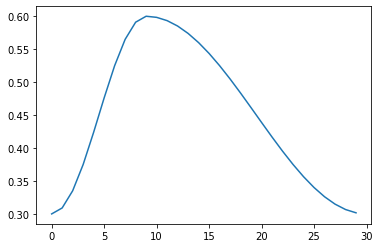

In [13]:
run.recorder.plot_lr()

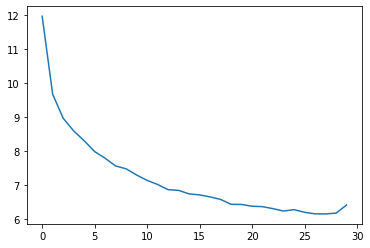

In [14]:
run.recorder.plot_loss()